In [130]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import ttest_ind

In [ ]:
# download other dataset just in case we want to extend analysis
# !wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years-violent.csv

In [ ]:
# !wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

In [214]:
compas = pd.read_csv("compas-scores-two-years.csv")
compas

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


In [215]:
# copy the pre-processing steps from "Loading Data" found on: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
compas = compas[(compas["days_b_screening_arrest"] <= 30) & (compas["days_b_screening_arrest"] >= -30)]

# nr of rows match those in link
sum(compas["is_recid"] & compas["two_year_recid"])

2809

In [216]:
# separate labels
compas_y = compas["two_year_recid"]
compas_X = compas.drop("two_year_recid", axis=1)

In [217]:
# remove irrelevant/replaceable features
compas_X = compas_X.drop(["id", "name", "first", "last", "compas_screening_date", 
                                    "dob", "age", "r_case_number", "vr_case_number", "type_of_assessment", 
                                    "decile_score.1", "v_screening_date", "priors_count.1", "c_case_number",
                                   "v_type_of_assessment", "violent_recid", "is_recid"], axis=1)

In [218]:
compas_X["event"].value_counts()

0    3766
1    2406
Name: event, dtype: int64

In [219]:
# convert dates to just years and numerical types
def date_to_justyear(date):
    if type(date) == str:
        return int(date[:4])
    
    return date

date_columns = ["c_jail_in", "c_jail_out", "c_offense_date", "c_arrest_date", "r_offense_date", 
                "r_jail_in", "r_jail_out", "vr_offense_date", "screening_date", "in_custody", "out_custody"]

for column in date_columns:
    compas_X[column] = compas_X[column].apply(func=date_to_justyear, convert_dtype=True)
    

In [220]:
# separate sensitive attributes
compas_sex = compas_X["sex"]
compas_race = compas_X["race"]
compas_X = compas_X.drop(["race", "sex"], axis=1)

In [221]:
# convert to one-hot-encoding
compas_cat_X = pd.get_dummies(compas_X)
compas_cat_X

,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,...,vr_charge_desc_Threat Public Servant,vr_charge_desc_Threaten Throw Destruct Device,vr_charge_desc_Throw Deadly Missile Into Veh,vr_charge_desc_Vehicular Homicide,score_text_High,score_text_Low,score_text_Medium,v_score_text_High,v_score_text_Low,v_score_text_Medium
0,0,1,0,0,0,-1.0,2013,2013,2013.0,NaN,...,0,0,0,0,0,1,0,0,1,0
1,0,3,0,0,0,-1.0,2013,2013,2013.0,NaN,...,0,0,0,0,0,1,0,0,1,0
2,0,4,0,1,4,-1.0,2013,2013,2013.0,NaN,...,0,0,0,0,0,1,0,0,1,0
5,0,1,0,0,0,0.0,2013,2013,2013.0,NaN,...,0,0,0,0,0,1,0,0,1,0
6,0,6,0,0,14,-1.0,2014,2014,2014.0,NaN,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0,7,0,0,0,-1.0,2013,2013,2013.0,NaN,...,0,0,0,0,0,0,1,0,0,1
7210,0,3,0,0,0,-1.0,2014,2014,2014.0,NaN,...,0,0,0,0,0,1,0,0,0,1
7211,0,1,0,0,0,-1.0,2014,2014,2014.0,NaN,...,0,0,0,0,0,1,0,0,1,0
7212,0,2,0,0,3,-1.0,2014,2014,2014.0,NaN,...,0,0,0,0,0,1,0,0,1,0


In [222]:
# impute the numerical missing values with the median
compas_cat_X = compas_cat_X.fillna(compas_cat_X.median())

In [223]:
# make a train and test split with same proportional size as Adult dataset
compas_train_cat_X, compas_test_cat_X, compas_train_y, compas_test_y= train_test_split(compas_cat_X, compas_y, test_size=1/3, random_state=42)

# also for the sensitive attributes with same random_state
compas_train_sex, compas_test_sex, compas_train_y, compas_test_y = train_test_split(compas_sex, compas_y, test_size=1/3, random_state=42)
compas_train_race, compas_test_race, compas_train_y, compas_test_y = train_test_split(compas_race, compas_y, test_size=1/3, random_state=42)

In [183]:
for column_name in compas_train_X.columns:
    print(f"{column_name} with Min: {compas_train_X.loc[compas_train_X[column_name].notna(), column_name].min()} and Max: {compas_train_X.loc[compas_train_X[column_name].notna(), column_name].max()}")

age_cat with Min: 25 - 45 and Max: Less than 25
juv_fel_count with Min: 0 and Max: 20
decile_score with Min: 1 and Max: 10
juv_misd_count with Min: 0 and Max: 8
juv_other_count with Min: 0 and Max: 9
priors_count with Min: 0 and Max: 33
days_b_screening_arrest with Min: -30.0 and Max: 30.0
c_jail_in with Min: 2013 and Max: 2015
c_jail_out with Min: 2013 and Max: 2015
c_offense_date with Min: 1992 and Max: 2014
c_arrest_date with Min: 2000 and Max: 2014
c_days_from_compas with Min: 0.0 and Max: 7604.0
c_charge_degree with Min: F and Max: M
c_charge_desc with Min: Abuse Without Great Harm and Max: arrest case no charge
is_recid with Min: 0 and Max: 1
r_charge_degree with Min: (CO3) and Max: (MO3)
r_days_from_arrest with Min: -1.0 and Max: 993.0
r_offense_date with Min: 2013 and Max: 2016
r_charge_desc with Min: Agg Batt W/Arm S/B/I 25 Min/Ma and Max: Wear Mask w/Commit Offense
r_jail_in with Min: 2013 and Max: 2016
r_jail_out with Min: 2013 and Max: 2020
is_violent_recid with Min: 0 and 

In [224]:
# construct decision tree
tree = DecisionTreeClassifier(random_state=42)

parameter_grid={"criterion":["entropy"], "max_depth":[2, 3, 4], 
                "max_features":["sqrt", None, "log2"], 
                "max_leaf_nodes":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
tree_cv = GridSearchCV(tree, param_grid=parameter_grid, scoring='balanced_accuracy', n_jobs=2, cv=3, verbose=2)
tree_cv.fit(compas_train_cat_X, compas_train_y)
best_tree = tree_cv.best_estimator_
best_tree

Fitting 3 folds for each of 90 candidates, totalling 270 fits


DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=7,
                       random_state=42)

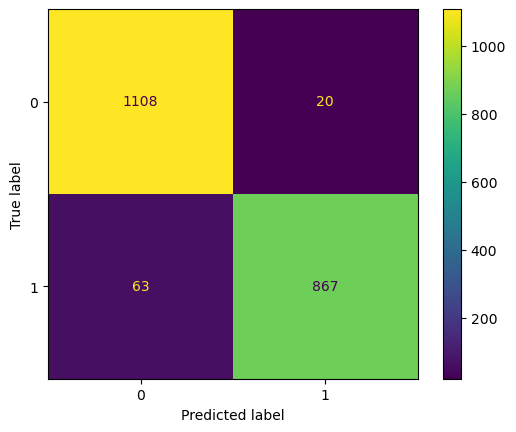

In [225]:
# confusion matrix / performance on testset
y_pred = best_tree.predict(compas_test_cat_X)
cm = confusion_matrix(compas_test_y, y_pred, labels=best_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_tree.classes_)
disp.plot()

In [226]:
print(f"Balanced accuracy on test set: {balanced_accuracy_score(compas_test_y, y_pred)}")
print(f"ROC-AUC score on test set: {roc_auc_score(compas_test_y, y_pred)}")
print(f"Accuracy score: {accuracy_score(compas_test_y, y_pred)}")

Balanced accuracy on test set: 0.9572637840311142
ROC-AUC score on test set: 0.9572637840311141
Accuracy score: 0.9596695821185617


In [227]:
column_names = [name for name in compas_train_cat_X.columns]
print(export_text(best_tree, feature_names=column_names))

|--- end <= 728.50
|   |--- event <= 0.50
|   |   |--- r_charge_degree_(M1) <= 0.50
|   |   |   |--- r_charge_degree_(F3) <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- r_charge_degree_(F3) >  0.50
|   |   |   |   |--- class: 1
|   |   |--- r_charge_degree_(M1) >  0.50
|   |   |   |--- class: 1
|   |--- event >  0.50
|   |   |--- class: 1
|--- end >  728.50
|   |--- event <= 0.50
|   |   |--- class: 0
|   |--- event >  0.50
|   |   |--- start <= 26.50
|   |   |   |--- class: 0
|   |   |--- start >  26.50
|   |   |   |--- class: 1



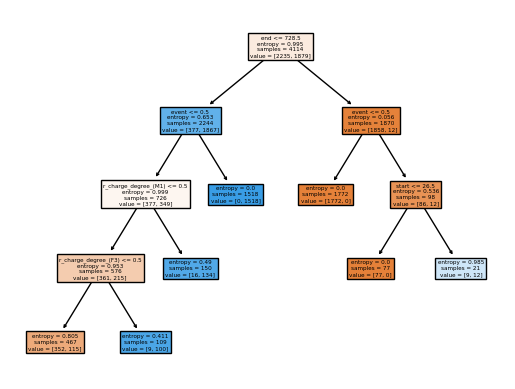

[CV] END criterion=entropy, max_depth=2, max_features=sqrt, max_leaf_nodes=3; total time=   0.4s
[CV] END criterion=entropy, max_depth=2, max_features=sqrt, max_leaf_nodes=4; total time=   0.3s
[CV] END criterion=entropy, max_depth=2, max_features=sqrt, max_leaf_nodes=4; total time=   0.4s
[CV] END criterion=entropy, max_depth=2, max_features=sqrt, max_leaf_nodes=5; total time=   0.2s
[CV] END criterion=entropy, max_depth=2, max_features=sqrt, max_leaf_nodes=6; total time=   0.2s
[CV] END criterion=entropy, max_depth=2, max_features=sqrt, max_leaf_nodes=6; total time=   0.2s
[CV] END criterion=entropy, max_depth=2, max_features=sqrt, max_leaf_nodes=7; total time=   0.2s
[CV] END criterion=entropy, max_depth=2, max_features=sqrt, max_leaf_nodes=8; total time=   0.2s
[CV] END criterion=entropy, max_depth=2, max_features=sqrt, max_leaf_nodes=8; total time=   0.2s
[CV] END criterion=entropy, max_depth=2, max_features=sqrt, max_leaf_nodes=9; total time=   0.2s
[CV] END criterion=entropy, ma

In [228]:
plot_tree(best_tree, feature_names=compas_train_cat_X.columns, filled=True)
plt.savefig("adulttree", dpi=800)
plt.show()